In [1]:
from utils import *
from helpers import *
import pandas as pd
from params import *
import os

### all scenarios

In [2]:
tstamp = '1023-145928'
RESULTS_PATH = os.path.join(OUTPUT_FOLDER_PATH,'experiments_'+tstamp)
idle = pd.read_csv(os.path.join(RESULTS_PATH, 'idle.csv'))
pax = pd.read_csv(os.path.join(RESULTS_PATH, 'pax.csv'))
state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))
trips = pd.read_csv(os.path.join(RESULTS_PATH, 'trips.csv'))
create_field_from_state_item(state, 4, 'delay')
create_field_from_state_item(state, 1, 'n_requests')

### validate parameters

In [3]:
# sns.histplot(state, x='n_requests', hue='scenario')

In [4]:
## expected number of requests at stop 1 and 3 based on inputs
request_rates = [sum(OD_MATRIX[2]), sum(OD_MATRIX[4])]
expected_requests_per_trip = [rr/(60/SCHEDULE_HEADWAY) for rr in request_rates]

## actual requests per trip
total_trip_stops = trips[(trips['stop'].isin(CONTROL_STOPS)) & (trips['scenario']=='DN')].groupby(['direction', 'stop']).size().reset_index().rename(columns={0:'n_trips'})
total_requests = pax[(pax['boarding_time'].isna()) & (pax['scenario']=='DN')].groupby(['direction', 'origin']).size().reset_index().rename(columns={0:'n_requests'})
total_requests['stop'] = total_requests['origin'] - 1
actuals = total_trip_stops.merge(total_requests, on=['direction', 'stop'], how='left')
actuals['requests_per_trip'] = (actuals['n_requests']/actuals['n_trips']).round(2)

In [5]:
def get_n_trips_over_time(data, stop=0, direction='out', scenario='DN'):
    all_trips = data[(data['stop']==stop) & (data['direction']==direction) & (data['scenario']==scenario)].copy()
    all_trips = all_trips.sort_values('arrival_time').reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = all_trips[all_trips['arrival_time']-all_trips['scheduled_time']<(SCHEDULE_TOLERANCE*60)].copy().drop(columns=['count'])

    all_trips = all_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    on_time_trips = on_time_trips.reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = on_time_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    return all_trips, on_time_trips

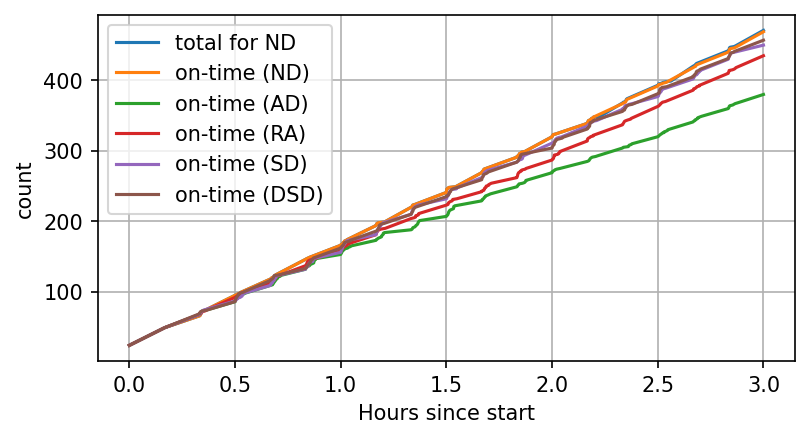

In [6]:
scenarios = ['ND', 'AD', 'RA','SD', 'DSD']
fig, axs = plt.subplots(figsize=(6,3))
for i in range(len(scenarios)):
    all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario=scenarios[i])
    all_trips['arrival_time'] = all_trips['arrival_time']/60/60
    on_time_trips['arrival_time'] = on_time_trips['arrival_time']/60/60
    if scenarios[i] == 'ND':
        sns.lineplot(data=all_trips, x='arrival_time', y='count', ax=axs, label='total for ND')
    sns.lineplot(data=on_time_trips, x='arrival_time', y='count', ax=axs, label=f'on-time ({scenarios[i]})')
    axs.set_xlabel('Hours since start')
    axs.grid(True)

In [7]:
state.groupby(['scenario'])['action'].sum()

scenario
AD     613
DSD    426
ND       0
RA     342
SD     541
Name: action, dtype: int64

In [8]:
table, table_pcts = tabulate_improvements(state, idle, pax, trips, base_scenario='ND', flex_stops=FLEX_STOPS)

In [9]:
table

,idle_time,wait_time,headway_cv,load,n_denied_riders,fixed_ridership,flex_ridership,tot_ridership,n_trips,avg_delay,served_rate
scenario,,,,,,,,,,,
AD,6.40,339.0,0.377,2.88,246,4763,840.0,5603,901,72.0,77.348066
DSD,8.08,311.0,0.152,2.71,445,4838,669.0,5507,913,6.0,60.053860
ND,14.16,309.0,0.119,2.25,1109,4878,NaN,4878,917,-22.0,NaN
RA,9.07,318.0,0.210,2.61,612,4866,483.0,5349,911,13.0,44.109589
SD,7.06,309.0,0.158,2.76,314,4805,788.0,5593,904,12.0,71.506352


In [ ]:
fig, axs = plt.subplots(figsize=(3,3))
sns.scatterplot(data=table, x='tot_ridership', y='otp', hue='scenario', ax=axs)
axs.set_xlabel('Total ridership')
axs.set_ylabel('OTP')
axs.axhline(y=80, color='black', linestyle='--')
axs.axvline(x=4200, color='black', linestyle='--')

In [ ]:
table

In [ ]:
table_pcts

In [ ]:
fig, axs = plt.subplots(figsize=(4,3))
sns.histplot(idle, x='idle_time', hue='scenario', common_norm=False)

In [ ]:
idle_for_plot = idle.copy()
idle_for_plot['idle_time'] = idle_for_plot['idle_time']/60/60
idle_for_plot['time'] = idle_for_plot['time']/60/60
plot_cumulative_idle_time(idle_for_plot)

### adding SG with 1 maximum minutes of delay

In [73]:
tstamp = '1014-163557'
RESULTS_PATH = os.path.join(OUTPUT_FOLDER_PATH,'experiments_'+tstamp)
idle = pd.read_csv(os.path.join(RESULTS_PATH, 'idle.csv'))
pax = pd.read_csv(os.path.join(RESULTS_PATH, 'pax.csv'))
state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))
trips = pd.read_csv(os.path.join(RESULTS_PATH, 'trips.csv'))
create_field_from_state_item(state, 4, 'delay')
create_field_from_state_item(state, 1, 'n_requests')

### validate parameters

In [74]:
# sns.histplot(state, x='n_requests', hue='scenario')

In [75]:
## expected number of requests at stop 1 and 3 based on inputs
request_rates = [sum(OD_MATRIX[2]), sum(OD_MATRIX[4])]
expected_requests_per_trip = [rr/(60/SCHEDULE_HEADWAY) for rr in request_rates]

## actual requests per trip
total_trip_stops = trips[(trips['stop'].isin(CONTROL_STOPS)) & (trips['scenario']=='DN')].groupby(['direction', 'stop']).size().reset_index().rename(columns={0:'n_trips'})
total_requests = pax[(pax['boarding_time'].isna()) & (pax['scenario']=='DN')].groupby(['direction', 'origin']).size().reset_index().rename(columns={0:'n_requests'})
total_requests['stop'] = total_requests['origin'] - 1
actuals = total_trip_stops.merge(total_requests, on=['direction', 'stop'], how='left')
actuals['requests_per_trip'] = (actuals['n_requests']/actuals['n_trips']).round(2)

In [76]:
def get_n_trips_over_time(data, stop=0, direction='out', scenario='DN'):
    all_trips = data[(data['stop']==stop) & (data['direction']==direction) & (data['scenario']==scenario)].copy()
    all_trips = all_trips.sort_values('arrival_time').reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = all_trips[all_trips['arrival_time']-all_trips['scheduled_time']<(SCHEDULE_TOLERANCE/60)].copy().drop(columns=['count'])

    all_trips = all_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    on_time_trips = on_time_trips.reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = on_time_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    return all_trips, on_time_trips

In [77]:
all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario='DN')
all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario='FG')

In [ ]:
scenarios = ['ND', 'AD', 'SD']
fig, axs = plt.subplots(figsize=(6,3))
for i in range(len(scenarios)):
    all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario=scenarios[i])
    all_trips['arrival_time'] = all_trips['arrival_time']/60/60
    on_time_trips['arrival_time'] = on_time_trips['arrival_time']/60/60
    if scenarios[i] == 'ND':
        sns.lineplot(data=all_trips, x='arrival_time', y='count', ax=axs, label='total for ND')
    sns.lineplot(data=on_time_trips, x='arrival_time', y='count', ax=axs, label=f'on-time ({scenarios[i]})')
    axs.set_xlabel('Hours since start')
    axs.grid(True)

In [ ]:
state.groupby(['scenario'])['action'].sum()

In [81]:
table, table_pcts = tabulate_improvements(state, idle, pax, trips, base_scenario='ND', flex_stops=FLEX_STOPS)

In [ ]:
fig, axs = plt.subplots(figsize=(3,3))
sns.scatterplot(data=table, x='tot_ridership', y='otp', hue='scenario', ax=axs)
axs.set_xlabel('Total ridership')
axs.set_ylabel('OTP')
axs.axhline(y=80, color='black', linestyle='--')
axs.axvline(x=4200, color='black', linestyle='--')

In [ ]:
table

In [ ]:
table_pcts

In [ ]:
fig, axs = plt.subplots(figsize=(4,3))
sns.histplot(idle, x='idle_time', hue='scenario', common_norm=False)

In [ ]:
idle_for_plot = idle.copy()
idle_for_plot['idle_time'] = idle_for_plot['idle_time']/60/60
idle_for_plot['time'] = idle_for_plot['time']/60/60
plot_cumulative_idle_time(idle_for_plot)

## debugging

In [1]:
from objects import RouteManager, EventManager

route = RouteManager()
event = EventManager()
event.start_vehicles(route)
route.load_all_pax()

obs, reward, terminated, truncated, info = event.step(route, action=None)
# while not terminated:
#     obs, reward, terminated, truncated, info = event.step(route, action=True)

In [ ]:
event.timestamps[-1]

In [ ]:
pax.groupby(['origin', 'destination']).size().reset_index()

In [ ]:
for direction in ('in', 'out'):
    for s in route.stops[direction]:
        if s.active_pax:
            print([(direction, p.origin, p.destination, p.arrival_time) for p in s.active_pax])